In [1]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')

    %cd drive/MyDrive/bmw-data-drift-detection/notebooks

    !pip install hydra-core omegaconf pytorch_lightning 

Dataset structure:

General structure
```
├── $OBJECT$
│   ├── ground_truth
│   │   ├── broken_large
│   │   ├── broken_small
│   │   └── contamination
│   ├── test
│   │   ├── broken_large
│   │   ├── broken_small
│   │   ├── contamination
│   │   └── good
│   └── train
│       └── good

```
Possible objects
```
├── bottle
├── cable
├── capsule
├── carpet
├── grid
├── hazelnut
├── leather
├── metal_nut
├── pill
├── screw
├── tile
├── toothbrush
├── transistor
├── wood
└── zipper

236 directories
```

In [2]:
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [3]:
target='bottle'

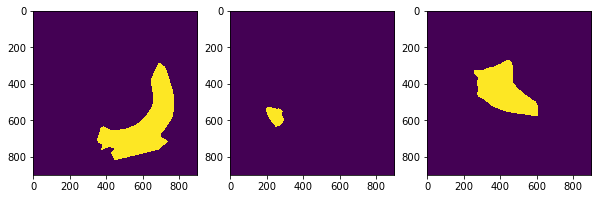

In [4]:
img_broken_large = mpimg.imread('../data/mvtec_anomaly_detection/' + target + '/ground_truth/broken_large/000_mask.png')
img_broken_small = mpimg.imread('../data/mvtec_anomaly_detection/' + target + '/ground_truth/broken_small/000_mask.png')
img_contamination = mpimg.imread('../data/mvtec_anomaly_detection/' + target + '/ground_truth/contamination/000_mask.png')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax[0].imshow(img_broken_large) 
ax[1].imshow(img_broken_small)
ax[2].imshow(img_contamination)

(900, 900, 3)


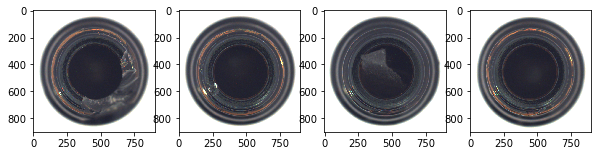

In [5]:
img_broken_large = mpimg.imread('../data/mvtec_anomaly_detection/' + target + '/test/broken_large/000.png')
img_broken_small = mpimg.imread('../data/mvtec_anomaly_detection/' + target + '/test/broken_small/000.png')
img_contamination = mpimg.imread('../data/mvtec_anomaly_detection/' + target + '/test/contamination/000.png')
img_good = mpimg.imread('../data/mvtec_anomaly_detection/' + target + '/test/good/000.png')
print(img_good.shape)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
ax[0].imshow(img_broken_large) 
ax[1].imshow(img_broken_small)
ax[2].imshow(img_contamination)
ax[3].imshow(img_good)

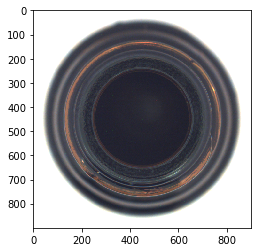

In [6]:
img = mpimg.imread('../data/mvtec_anomaly_detection/' + target + '/train/good/000.png')
imgplot = plt.imshow(img)

In [7]:
img.shape

(900, 900, 3)

In [8]:
import os,sys,inspect
import hydra
import omegaconf
import torch
from omegaconf import DictConfig

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from models import AE
from src import mvtec_loader as mloader

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint 
import torchvision as tv

import numpy as np
from src import utils
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from torch.nn import functional as F

In [9]:
import pytorch_lightning
pytorch_lightning.__version__

'1.4.0'

In [10]:
cfg = omegaconf.OmegaConf.load('../config/config.yaml')
cfg.exp.model = "AE"

In [11]:
transform  = tv.transforms.Compose([tv.transforms.ToPILImage(),
                                    #tv.transforms.Grayscale(num_output_channels=3),
                                    tv.transforms.Resize((cfg.arch.cnn_enc.input_height, cfg.arch.cnn_enc.input_width)),
                                    tv.transforms.ToTensor(), 
                                    #tv.transforms.Normalize((0.5,), (0.5,))
                                   ])

mvtec_loader = mloader.MVTecADDataset(data_root='../data/mvtec_anomaly_detection', 
                                      results_root=os.path.join('../', cfg.exp.results_path, '_' + cfg.exp.run_id),
                                      targets=[target], 
                                      create_or_load=True,
                                      reprod=True,
                                      idx_file='idx_' + cfg.exp.run_id, #+ '_split.pkl',
                                      targets_file='targets_' + cfg.exp.run_id, # + '.pkl',
                                      transforms=transform,
                                      batch_size=cfg.exp.batch_size,
                                      val_ratio=0.0,
                                      num_workers=cfg.data.num_workers)

targets to be used are:  bottle


-----

Training autoencoders

In [12]:
model = AE.AE(cfg)

In [ ]:
early_stop_callback = EarlyStopping(monitor= 'train_loss',
                                    min_delta=0.00, 
                                    patience=cfg.exp.early_stopping_patience, 
                                    verbose=False, 
                                    mode='min')
#checkpoint_callback = CustomModelCheckpoint(model=model, verbose=True, monitor='val_loss', mode='min', save_top_k=1)
lr_logging_callback = LearningRateMonitor(logging_interval='epoch')
checkpoint_callback = ModelCheckpoint(save_last=True, 
                                      save_top_k=1, 
                                      monitor="train_loss", 
                                      every_n_epochs=1)
trainer = Trainer(gpus=1,
                  max_epochs=cfg.exp.max_epochs,
                  #auto_lr_find=self.args.optimizer.auto_lr_find,
                  accelerator='dp',
                  log_every_n_steps=5,
                  profiler='simple',
                  check_val_every_n_epoch=cfg.exp.check_val_every_n_epoch,
                  callbacks=[lr_logging_callback, early_stop_callback])

trainer.fit(model, datamodule=mvtec_loader)
trainer.test(model, datamodule=mvtec_loader)

In [ ]:
trainer.save_checkpoint("model_small_ae.ckpt")

### Reconstrucitons

In [ ]:
#just check
model.eval()
model = model.to(model.device)
reconstructions = []
cnt = 0
for batch in mvtec_loader.test_dataloader():
    cnt = cnt + 1
    X, _ = batch
    X = X.to(model.device)
    flattened_X = X.view(X.shape[0], -1)
    print(flattened_X.shape)
    reconstruction = model.forward(flattened_X)
    reconstruction = reconstruction.view(X.shape[0], -1)
    print(reconstruction.shape)
    print(F.mse_loss(reconstruction, flattened_X, reduction = 'mean'))
    reconstructions.append(reconstruction.view(-1,
                                               cfg.arch.cnn_dec.out_channels,
                                               cfg.arch.cnn_dec.output_height,
                                               cfg.arch.cnn_dec.output_width).cpu().detach().numpy())

In [12]:
#change to function load model
cfg = omegaconf.OmegaConf.load('../config/config.yaml')
cfg.arch.embedding_size = 8 
cfg.arch.cnn_enc.output_size = 8

model = AE.AE.load_from_checkpoint('./model_small_ae.ckpt', args=cfg)

processing the batch: 0
processing the batch: 1
processing the batch: 2
processing the batch: 3
processing the batch: 4
Original images


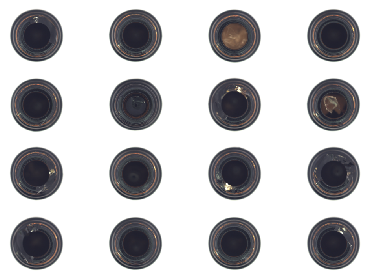

Transformed


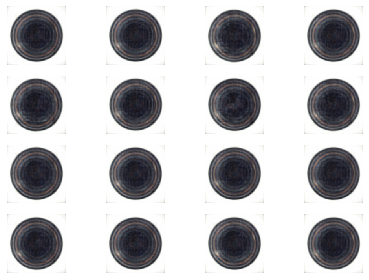

Reconstruction error for labels  {2: 0.004237502, 1: 0.0037000002, 3: 0.0048584864, 0: 0.0027811446}


In [13]:
utils.reconstruction_vis(model, mvtec_loader.test_dataloader(), n_batches=10, batch_size=cfg.exp.batch_size)

targets to be used are:  transistor
processing the batch: 0
processing the batch: 1
processing the batch: 2
processing the batch: 3
processing the batch: 4
processing the batch: 5
Original images


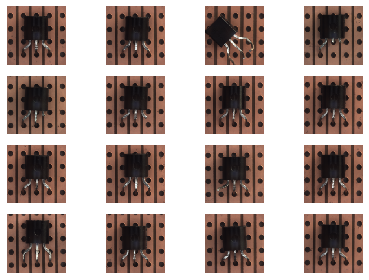

Transformed


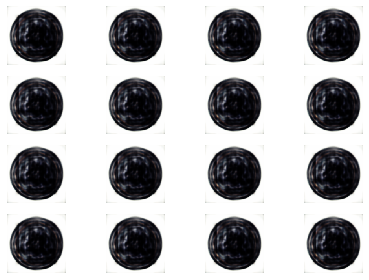

Reconstruction error for labels  {0: 0.16101165, 4: 0.16055143, 3: 0.1584647, 1: 0.15988292, 2: 0.17132746}


In [14]:
mvtec_loader_tr = mloader.MVTecADDataset(data_root='../data/mvtec_anomaly_detection', 
                                      results_root=os.path.join('../', cfg.exp.results_path, '_' + cfg.exp.run_id),
                                      targets=['transistor'], 
                                      create_or_load=True,
                                      reprod=True,
                                      idx_file='idx_' + cfg.exp.run_id, #+ '_split.pkl',
                                      targets_file='targets_' + cfg.exp.run_id, # + '.pkl',
                                      transforms=transform,
                                      batch_size=cfg.exp.batch_size,
                                      val_ratio=0.0,
                                      num_workers=cfg.data.num_workers)

utils.reconstruction_vis(model, mvtec_loader_tr.test_dataloader(), n_batches=10, batch_size=cfg.exp.batch_size)

targets to be used are:  hazelnut
processing the batch: 0
processing the batch: 1
processing the batch: 2
processing the batch: 3
processing the batch: 4
processing the batch: 5
Original images


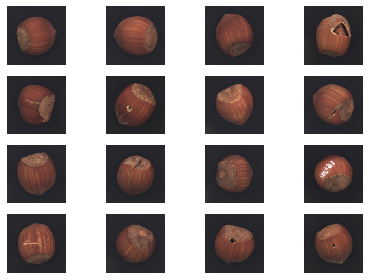

Transformed


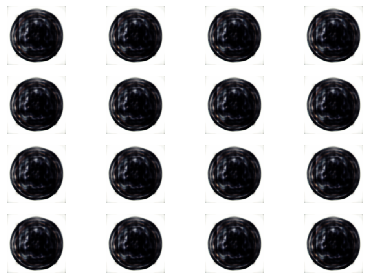

Reconstruction error for labels  {1: 0.26578522, 0: 0.26149338, 3: 0.26377004, 2: 0.27976894, 4: 0.26553}


In [15]:
mvtec_loader_hz = mloader.MVTecADDataset(data_root='../data/mvtec_anomaly_detection', 
                                      results_root=os.path.join('../', cfg.exp.results_path, '_' + cfg.exp.run_id),
                                      targets=['hazelnut'], 
                                      create_or_load=True,
                                      reprod=True,
                                      idx_file='idx_' + cfg.exp.run_id, #+ '_split.pkl',
                                      targets_file='targets_' + cfg.exp.run_id, # + '.pkl',
                                      transforms=transform,
                                      batch_size=cfg.exp.batch_size,
                                      val_ratio=0.0,
                                      num_workers=cfg.data.num_workers)
utils.reconstruction_vis(model, mvtec_loader_hz.test_dataloader(), n_batches=10, batch_size=cfg.exp.batch_size)

## PCA and visualisation

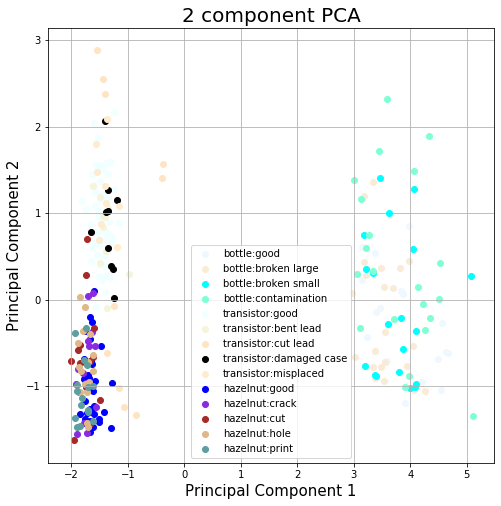

In [16]:
bottle_rerps, bottle_labels = utils.get_representations(model, mvtec_loader.test_dataloader())
transistor_reprs, transistor_labels = utils.get_representations(model, mvtec_loader_tr.test_dataloader())
hz_reprs, hz_labels = utils.get_representations(model, mvtec_loader_hz.test_dataloader())

# shift labels so that they won't be intersecting
bottle_labels = bottle_labels.flatten()
transistor_labels = transistor_labels.flatten() + (max(bottle_labels) + 1)
hz_labels += (max(transistor_labels) + 1)

y = list(bottle_labels)
y.extend(list(transistor_labels))
y.extend(list(hz_labels.flatten()))
y = np.array(y)

x = []

for reprs in [bottle_rerps, transistor_reprs, hz_reprs]:
    for batch in reprs:
        for obj in batch:
            x.append(obj.tolist())
            
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

pc1 = principalComponents[:, 0]
pc2 = principalComponents[:, 1]

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

colors = list(mcolors.CSS4_COLORS.values())
labels = {
    0 : "bottle:good",
    1 : "bottle:broken large",
    2 : "bottle:broken small",
    3 : "bottle:contamination",
    4 : "transistor:good",
    5 : "transistor:bent lead",
    6 : "transistor:cut lead",
    7 : "transistor:damaged case",
    8 : "transistor:misplaced",
    9 : "hazelnut:good",
    10: "hazelnut:crack",
    11: "hazelnut:cut",
    12: "hazelnut:hole",
    13: "hazelnut:print",

}

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

for k, v in labels.items():
    ax.scatter(pc1[y == k], pc2[y == k], c=colors[k], label=v)

#ax.scatter(pc1[y == 1], pc2[y == 1], c='g', label='transistor')

ax.legend()
ax.grid()

### Bigger AE visualisation

In [17]:
cfg = omegaconf.OmegaConf.load('../config/config.yaml')
model = AE.AE.load_from_checkpoint('./model_ae.ckpt', args=cfg)

processing the batch: 0
processing the batch: 1
processing the batch: 2
processing the batch: 3
processing the batch: 4
Original images


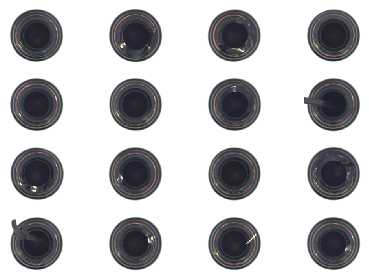

Transformed


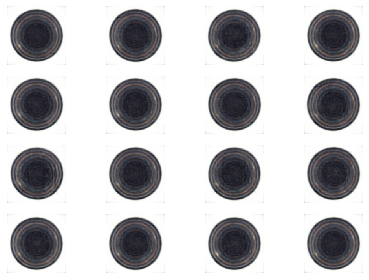

Reconstruction error for labels  {2: 0.0028919186, 3: 0.0032699362, 1: 0.0025343616, 0: 0.0013836422}


In [18]:
utils.reconstruction_vis(model, mvtec_loader.test_dataloader(), n_batches=10, batch_size=cfg.exp.batch_size)

targets to be used are:  transistor
processing the batch: 0
processing the batch: 1
processing the batch: 2
processing the batch: 3
processing the batch: 4
processing the batch: 5
Original images


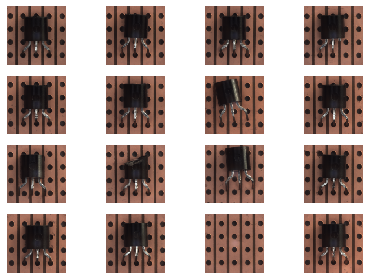

Transformed


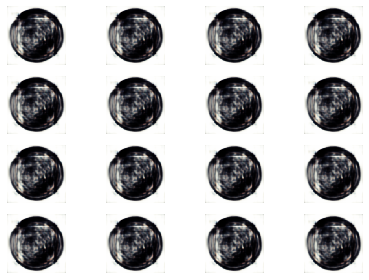

Reconstruction error for labels  {0: 0.16451877, 2: 0.16707587, 4: 0.16375121, 1: 0.16310637, 3: 0.16202343}


In [19]:
mvtec_loader_tr = mloader.MVTecADDataset(data_root='../data/mvtec_anomaly_detection', 
                                      results_root=os.path.join('../', cfg.exp.results_path, '_' + cfg.exp.run_id),
                                      targets=['transistor'], 
                                      create_or_load=True,
                                      reprod=True,
                                      idx_file='idx_' + cfg.exp.run_id, #+ '_split.pkl',
                                      targets_file='targets_' + cfg.exp.run_id, # + '.pkl',
                                      transforms=transform,
                                      batch_size=cfg.exp.batch_size,
                                      val_ratio=0.0,
                                      num_workers=cfg.data.num_workers)

utils.reconstruction_vis(model, mvtec_loader_tr.test_dataloader(), n_batches=10, batch_size=cfg.exp.batch_size)

targets to be used are:  hazelnut
processing the batch: 0
processing the batch: 1
processing the batch: 2
processing the batch: 3
processing the batch: 4
processing the batch: 5
Original images


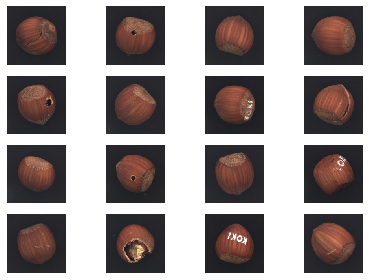

Transformed


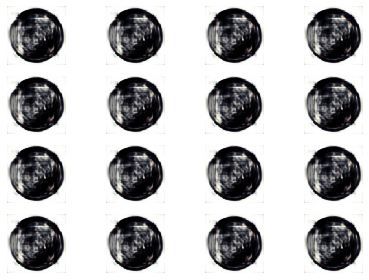

Reconstruction error for labels  {3: 0.24991243, 1: 0.25177392, 2: 0.2639498, 0: 0.24673314, 4: 0.25179687}


In [20]:
mvtec_loader_hz = mloader.MVTecADDataset(data_root='../data/mvtec_anomaly_detection', 
                                      results_root=os.path.join('../', cfg.exp.results_path, '_' + cfg.exp.run_id),
                                      targets=['hazelnut'], 
                                      create_or_load=True,
                                      reprod=True,
                                      idx_file='idx_' + cfg.exp.run_id, #+ '_split.pkl',
                                      targets_file='targets_' + cfg.exp.run_id, # + '.pkl',
                                      transforms=transform,
                                      batch_size=cfg.exp.batch_size,
                                      val_ratio=0.0,
                                      num_workers=cfg.data.num_workers)

utils.reconstruction_vis(model, mvtec_loader_hz.test_dataloader(), n_batches=10, batch_size=cfg.exp.batch_size)

In [21]:
import pickle

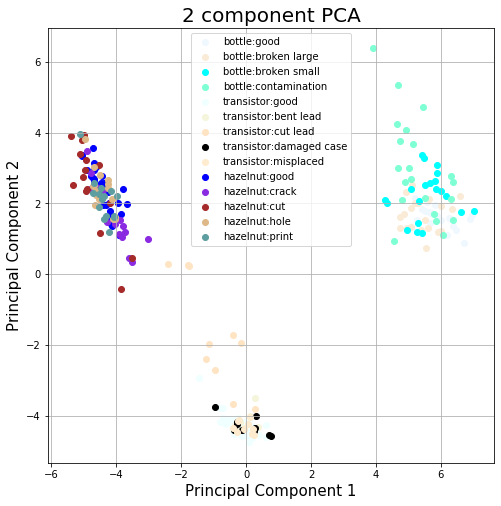

In [22]:
bottle_rerps, bottle_labels = utils.get_representations(model, mvtec_loader.test_dataloader())
transistor_reprs, transistor_labels = utils.get_representations(model, mvtec_loader_tr.test_dataloader())
hz_reprs, hz_labels = utils.get_representations(model, mvtec_loader_hz.test_dataloader())

# shift labels so that they won't be intersecting
bottle_labels = bottle_labels.flatten()
transistor_labels = transistor_labels.flatten() + (max(bottle_labels) + 1)
hz_labels += (max(transistor_labels) + 1)

y = list(bottle_labels)
y.extend(list(transistor_labels))
y.extend(list(hz_labels.flatten()))
y = np.array(y)

x = []

    

for reprs in [bottle_rerps, transistor_reprs, hz_reprs]:
    for batch in reprs:
        for obj in batch:
            x.append(obj.tolist())

with open('whole_rprs.pkl', 'wb') as handle:
    pickle.dump(x, handle)
    
with open('whole_lbls.pkl', 'wb') as handle:
    pickle.dump(y, handle)

            
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

pc1 = principalComponents[:, 0]
pc2 = principalComponents[:, 1]

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

colors = list(mcolors.CSS4_COLORS.values())
labels = {
    0 : "bottle:good",
    1 : "bottle:broken large",
    2 : "bottle:broken small",
    3 : "bottle:contamination",
    4 : "transistor:good",
    5 : "transistor:bent lead",
    6 : "transistor:cut lead",
    7 : "transistor:damaged case",
    8 : "transistor:misplaced",
    9 : "hazelnut:good",
    10: "hazelnut:crack",
    11: "hazelnut:cut",
    12: "hazelnut:hole",
    13: "hazelnut:print",

}

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

for k, v in labels.items():
    ax.scatter(pc1[y == k], pc2[y == k], c=colors[k], label=v)

ax.legend()
ax.grid()

In [23]:
pca.explained_variance_ratio_.sum()

0.8082414888544691